<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [238]:
# Importing required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import jaccard_score, f1_score
import math

This function is to plot the confusion matrix.


In [239]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"

    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Did not Land', 'Landed']); ax.yaxis.set_ticklabels(['Did not Land', 'Landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [240]:
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
data = pd.read_csv(URL1)

In [241]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [242]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
X = pd.read_csv(URL2)

In [243]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [244]:
Y = data['Class'].to_numpy()
Y[0:5] # Displaying first 5 elements of Y

array([0, 0, 0, 0, 0], dtype=int64)

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [245]:
# students get this 
transform = StandardScaler()
X = transform.fit_transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [246]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

we can see we only have 18 test samples.


In [247]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [248]:
parameters ={"C":[0.01,0.1,1],
             'penalty':['l2'], 
             'solver':['lbfgs']}# l1 lasso l2 ridge

In [249]:
lr=LogisticRegression()

logreg_cv=GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [250]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [251]:
lr_acc = logreg_cv.score(X_test, Y_test)
lr_acc = round(lr_acc * 100, 2)
lr_acc

83.33

Lets look at the confusion matrix:


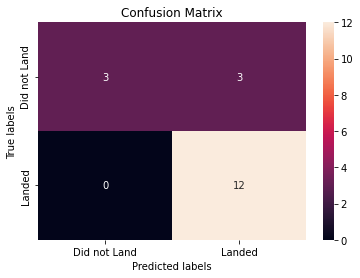

In [252]:
lr_yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,lr_yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [253]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [254]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [255]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [256]:
svm_acc = svm_cv.score(X_test, Y_test)
svm_acc = round(svm_acc * 100, 2)
svm_acc

83.33

We can plot the confusion matrix


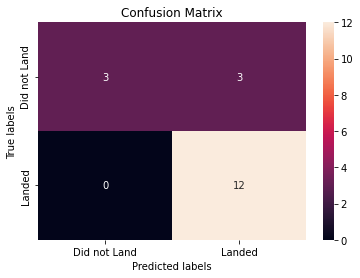

In [257]:
svm_yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,svm_yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [258]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt', 'log2'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [259]:
dt_cv = GridSearchCV(tree, parameters, cv=10)
dt_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [260]:
print("tuned hpyerparameters :(best parameters) ",dt_cv.best_params_)
print("accuracy :",dt_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.875


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [261]:
dt_acc = dt_cv.score(X_test, Y_test)
dt_acc = round(dt_acc * 100, 2) 
dt_acc

88.89

We can plot the confusion matrix


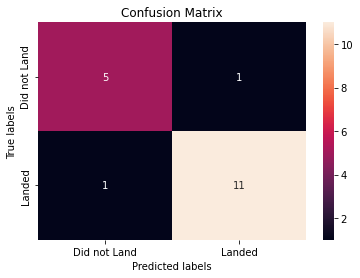

In [262]:
dt_yhat = dt_cv.predict(X_test)
plot_confusion_matrix(Y_test,dt_yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [263]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [264]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [265]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [266]:
knn_acc = knn_cv.score(X_test, Y_test)
knn_acc = round(knn_acc * 100, 2)
knn_acc

83.33

We can plot the confusion matrix


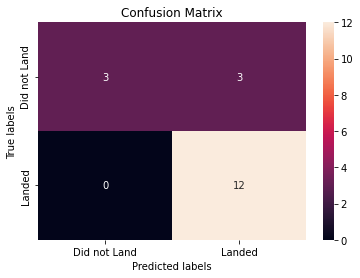

In [267]:
knn_yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,knn_yhat)

## TASK  12


Find the method performs best:


In [268]:
# Examining the scores from Test sets
jaccard_scores = [
                  jaccard_score(Y_test, lr_yhat),
                  jaccard_score(Y_test, svm_yhat),
                  jaccard_score(Y_test, dt_yhat),
                  jaccard_score(Y_test, knn_yhat),
                 ]

f1_scores = [
             f1_score(Y_test, lr_yhat),
             f1_score(Y_test, svm_yhat),
             f1_score(Y_test, dt_yhat),
             f1_score(Y_test, knn_yhat),
            ]

jaccard_scores = [(round(num, -int(math.floor(math.log10(abs(num)))) + 2) * 100) for num in jaccard_scores]
f1_scores = [(round(num, -int(math.floor(math.log10(abs(num)))) + 2) * 100) for num in f1_scores]
accuracy = [lr_acc, svm_acc, dt_acc, knn_acc]

test_scores = pd.DataFrame(np.array([jaccard_scores, f1_scores, accuracy]), 
                           index=['Jaccard Score', 'F1 Score', 'Accuracy'] , 
                           columns=['Logistic Regression', 'SVM', 'Decision Tree', 'KNN'])
test_scores

,Logistic Regression,SVM,Decision Tree,KNN
Jaccard Score,80.00,80.00,84.60,80.00
F1 Score,88.90,88.90,91.70,88.90
Accuracy,83.33,83.33,88.89,83.33


In [269]:
# Examining the scores from the whole Dataset
jaccard_scores = [
                  jaccard_score(Y, logreg_cv.predict(X)),
                  jaccard_score(Y, svm_cv.predict(X)),
                  jaccard_score(Y, dt_cv.predict(X)),
                  jaccard_score(Y, knn_cv.predict(X)),
                 ]

f1_scores = [
             f1_score(Y, logreg_cv.predict(X)),
             f1_score(Y, svm_cv.predict(X)),
             f1_score(Y, dt_cv.predict(X)),
             f1_score(Y, knn_cv.predict(X)),
            ]

jaccard_scores = [(round(num, -int(math.floor(math.log10(abs(num)))) + 2) * 100) for num in jaccard_scores]
f1_scores = [(round(num, -int(math.floor(math.log10(abs(num)))) + 2) * 100) for num in f1_scores]
accuracy = [logreg_cv.score(X, Y), svm_cv.score(X, Y), dt_cv.score(X, Y), knn_cv.score(X, Y)]
accuracy = [(round(num, -int(math.floor(math.log10(abs(num)))) + 2) * 100) for num in accuracy]

train_scores = pd.DataFrame(np.array([jaccard_scores, f1_scores, accuracy]),
                      index=['Jaccard Score', 'F1 Score', 'Accuracy'],
                      columns=['Logistic Regression', 'SVM', 'Decision Tree', 'KNN'])
train_scores

,Logistic Regression,SVM,Decision Tree,KNN
Jaccard Score,83.3,84.5,81.8,81.9
F1 Score,90.9,91.6,90.0,90.1
Accuracy,86.7,87.8,86.7,85.6


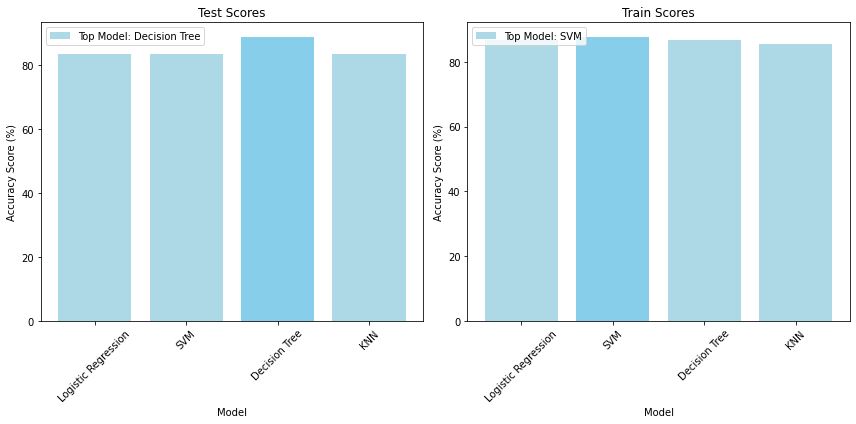

In [270]:
# Find the top-performing model in terms of accuracy score from test_scores
top_test_model = test_scores.idxmax(axis=1)['Accuracy']

# Find the top-performing model in terms of accuracy score from train_scores
top_train_model = train_scores.idxmax(axis=1)['Accuracy']

# Get the accuracy scores of all models
test_accuracy_scores = test_scores.loc['Accuracy']
train_accuracy_scores = train_scores.loc['Accuracy']

# Create subplot with two bar charts
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot test scores
axs[0].bar(test_accuracy_scores.index, test_accuracy_scores, color='lightblue')
axs[0].set_title('Test Scores')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Accuracy Score (%)')

# Highlight top test model
axs[0].bar(top_test_model, test_accuracy_scores[top_test_model], color='skyblue')

# Plot train scores
axs[1].bar(train_accuracy_scores.index, train_accuracy_scores, color='lightblue')
axs[1].set_title('Train Scores')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Accuracy Score (%)')

# Highlight top train model
axs[1].bar(top_train_model, train_accuracy_scores[top_train_model], color='skyblue')

# Add legend indicating the top-performing models
axs[0].legend([f'Top Model: {top_test_model}'], loc='upper left')
axs[1].legend([f'Top Model: {top_train_model}'], loc='upper left')

# Rotate x-axis labels for better visibility
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
